In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras.layers as L
from keras.models import Sequential
import os

In [ ]:
builder = tfds.ImageFolder('train_small')
ds = builder.as_dataset(split='train', shuffle_files=True)#5411

labels = np.matrix(pd.read_csv('train_small.csv'))[:, 2]

def map_dataset(next):
    num = tf.strings.split(next['image/filename'], sep='\\')[-1]
    num = tf.strings.split(num, sep='.')[0]
    num = tf.strings.to_number(num, out_type=tf.int32)

    img = tf.image.resize(next['image'] / 255, (64, 64))

    return {'image': img, 'label': num}

ds = ds.map(map_dataset)

next = ds.as_numpy_iterator().next()
plt.figure()
plt.imshow(next['image'])
plt.title(labels[next['label']][0, 0])
plt.show()

In [37]:
# Get data matrix
def get_data_matrix(path: str):
    N = len(os.listdir(path))
    list_files = [str(i) + '.jpg' for i in range(N)]

    X = np.zeros((len(list_files), 64, 64, 3))
    for i, f in enumerate(list_files):
        img = plt.imread(os.path.join(path, f)) / 255
        
        # If black and white, convert to RGB
        if len(img.shape) == 2:
            img = np.stack((img, img, img), axis=2)
        
        # If it is a gif, take the first frame
        if img.shape[2] == 4:
            img = img[:, :, :3]

        img = tf.image.resize(img, (64, 64))
        X[i] = img
    return X

X_train = get_data_matrix('train')
X_test = get_data_matrix('test')

C:\Users\jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [39]:
# Get labels array
labels = np.matrix(pd.read_csv('train_small.csv'))[:, 2]
categories = np.matrix(pd.read_csv('category.csv'))[:, 1]

y_train = np.empty(labels.size)
for i in range(y_train.size):
    y_train[i] = np.where(categories == labels[i])[0]

Text(0.5, 1.0, 'Angelina Jolie')

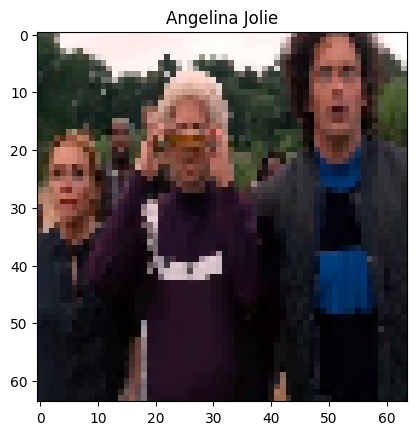

In [40]:
plt.figure()
plt.imshow(X_train[-9])
plt.title(labels[-9][0, 0])
plt.show()

In [41]:
def build_model():
    model = Sequential()
    model.add(L.Conv2D(32, 5, activation='relu', input_shape=(64, 64, 3)))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Conv2D(64, 5, activation='relu'))
    model.add(L.MaxPooling2D((2, 2)))
    model.add(L.Conv2D(128, 5, activation='relu'))
    model.add(L.Flatten())
    model.add(L.Dense(100, activation='relu'))
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 128)         204928    
                                                                 
 flatten_1 (Flatten)         (None, 10368)            

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=1)

KeyboardInterrupt: 

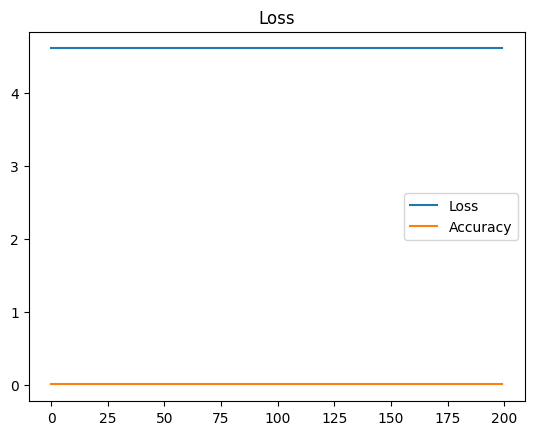

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
y_test = np.argmax(model.predict(X_test), axis=1)

156/156 [==============================] - 4s 26ms/step


In [ ]:
# Save predictions
pred = [categories[y_test[i]][0, 0] for i in range(y_test.size)]
df = pd.DataFrame(pred, columns=['Category'])
df.index.name = 'Id'
df.to_csv('submission.csv')